In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array

warnings.filterwarnings("ignore")
import random

# CREATE TEST-TRAIN SPLIT

Creating a good train-test split is essential for evaluating the performance of your machine learning model. Here are some guidelines to help you make an effective train-test split:

## Understand the Purpose:

The train-test split is used to evaluate the model's performance on unseen data. The training set is used to train the model, while the test set is used to assess its generalization ability.

### Hint: Common Split Ratios:

Typical split ratios are 70-30, 80-20, or 90-10, where the larger portion is used for training and the smaller portion for testing. For example, an 80-20 split means 80% of the data is used for training and 20% for testing.

In [9]:
train_csv_path = '/kaggle/input/pizza-or-not-pizza-serpentine-competition/train.csv'
test_csv_path = '/kaggle/input/pizza-or-not-pizza-serpentine-competition/test.csv'
images_dir = '/kaggle/input/pizza-or-not-pizza-serpentine-competition/images/images'

# Load train and test CSVs
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)


# Helper function to load images
def load_images(df, images_dir, img_size=(224, 224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(images_dir, row['id'])
        img = load_img(img_path, target_size=img_size)  # Resize image
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
        if 'label' in row:  # Only include labels for training data
            labels.append(row['label'])
    return np.array(images), np.array(labels) if labels else None

# Load training images and labels
X_train, y_train = load_images(train_df, images_dir)

# Load test images (no labels)
X_test, _ = load_images(test_df, images_dir)

# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [10]:
print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (1100, 224, 224, 3), Train labels shape: (1100,)
Validation data shape: (276, 224, 224, 3), Validation labels shape: (276,)
Test data shape: (590, 224, 224, 3)


In [11]:
try:
    # Detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    # Connect to the TPU cluster
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    # If TPU is not available, fallback to default strategy
    strategy = tf.distribute.get_strategy()
    print("Using default strategy")

print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

Using default strategy
Number of accelerators: 1


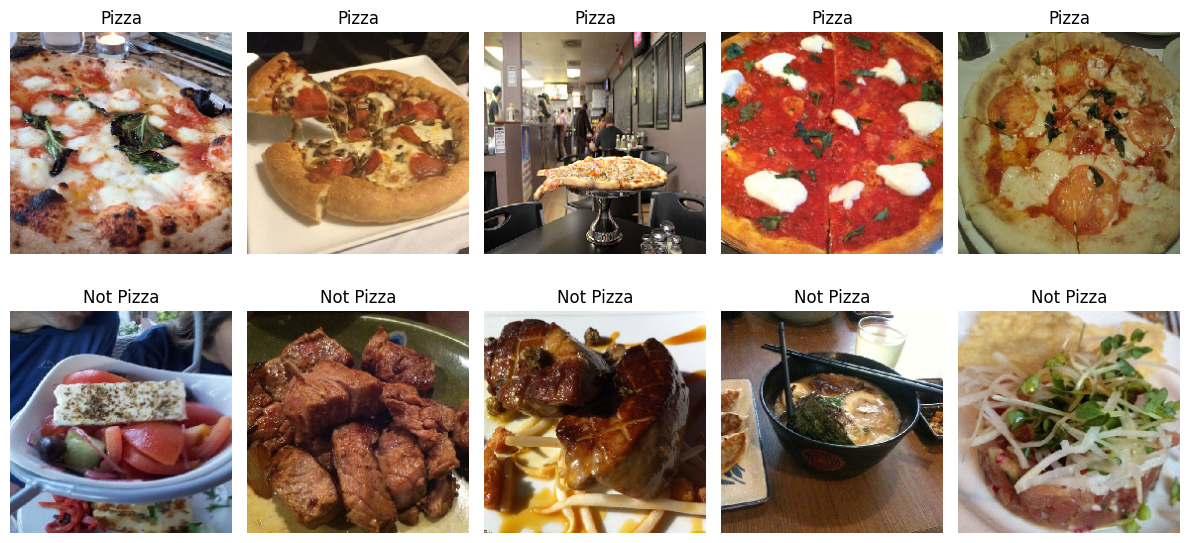

In [12]:
# Select random indices for 'pizza' (label=1) and 'not_pizza' (label=0)
num_images = 5  # Number of images to display from each class

# Separate image IDs by label
pizza_ids = train_df[train_df['label'] == 1]['id'].values
not_pizza_ids = train_df[train_df['label'] == 0]['id'].values

# Randomly sample image IDs
random_pizza_ids = random.sample(list(pizza_ids), num_images)
random_not_pizza_ids = random.sample(list(not_pizza_ids), num_images)

# Create subplots for displaying images
plt.figure(figsize=(12, 6))
for i, image_id in enumerate(random_pizza_ids + random_not_pizza_ids):
    # Determine label
    label = 'Pizza' if i < num_images else 'Not Pizza'

    # Load the image
    img_path = os.path.join(images_dir, image_id)
    img = load_img(img_path, target_size=(224, 224))  # Adjust target size if needed
    img_array = img_to_array(img) / 255.0  # Normalize for display

    # Display the image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(img_array)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


# CHOOSE BATCH SIZE

Choosing the right batch size is important for the efficiency and performance of your machine learning model. Here are some guidelines to help you choose a good batch size:

## Understand Batch Size

The batch size is the number of training examples used in one iteration of model training. It determines how often the model's weights are updated.

## Common Batch Sizes

Common batch sizes are powers of 2, such as 16, 32, 64, 128, and 256. These sizes are often chosen because they align well with the memory architecture of modern GPUs.


In [14]:
# Image Data Generators for training and validation with data augmentation

#TODO: Define batch_size
batch_size = 64
#END TODO

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)



# SET LEARNING RATE
 Hint: Begin with a small learning rate, such as `0.001` or `0.0001`. This ensures that the model parameters are updated slowly and helps avoid overshooting the optimal solution.




In [15]:
rate_learning = 0.001

# DEFINE MODEL ARCHITECTURE

In [17]:
# Define the CNN model

#TODO: Define Model architecture
with strategy.scope():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', 
               input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
    
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
    
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    #END TODO
    model.compile(optimizer=Adam(learning_rate=rate_learning),
                   
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# DEFINE PATIENCE FOR EARLY STOPPING

Early stopping is a technique used to prevent overfitting by halting the training process when the model's performance on a validation set stops improving. The patience parameter is a key component of early stopping. Here are some guidelines to help you define the patience for early stopping:

## Understand Patience:

Patience is the number of epochs to wait after the last improvement in the monitored metric (e.g., validation loss) before stopping the training. If the metric does not improve for a specified number of epochs, training is stopped.

### Hint: Start with a Baseline:

Begin with a baseline patience value, such as 5 or 10 epochs. This provides a starting point to observe the model's performance and training behavior.

In [18]:
# Early stopping to prevent overfitting

#TODO: Define patience for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
#END TODO

# DEFINE NUMBER OF EPOCH FOR TRAINING
Choosing the right number of epochs is crucial for training a machine learning model effectively. Here are some guidelines to help you determine a suitable number of epochs:

## Understand Epochs:

An epoch is one complete pass through the entire training dataset. During each epoch, the model's weights are updated based on the training data.

### Hint: Start with a baseline

Begin with a baseline number of epochs, such as 10, 50, or 100. This provides a starting point to observe the model's performance and training behavior.


In [19]:
# Train the model

#TODO: Define the number of epochs
epochs = 20
#END TODO
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5303 - loss: 1.1363 - val_accuracy: 0.5181 - val_loss: 0.7610
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5776 - loss: 0.6837 - val_accuracy: 0.6739 - val_loss: 0.6413
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.7123 - loss: 0.6071 - val_accuracy: 0.5326 - val_loss: 0.8036
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7082 - loss: 0.5553 - val_accuracy: 0.6558 - val_loss: 0.6178
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.7334 - loss: 0.5289 - val_accuracy: 0.6957 - val_loss: 0.5839
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7745 - loss: 0.4807 - val_accuracy: 0.6920 - val_loss: 0.6391
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7981 - loss: 0.4620 - val_accuracy: 0.7210 - val_loss: 0.5798
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.8330 - loss: 0.3854 - val_accuracy: 0.6993 - val_loss:

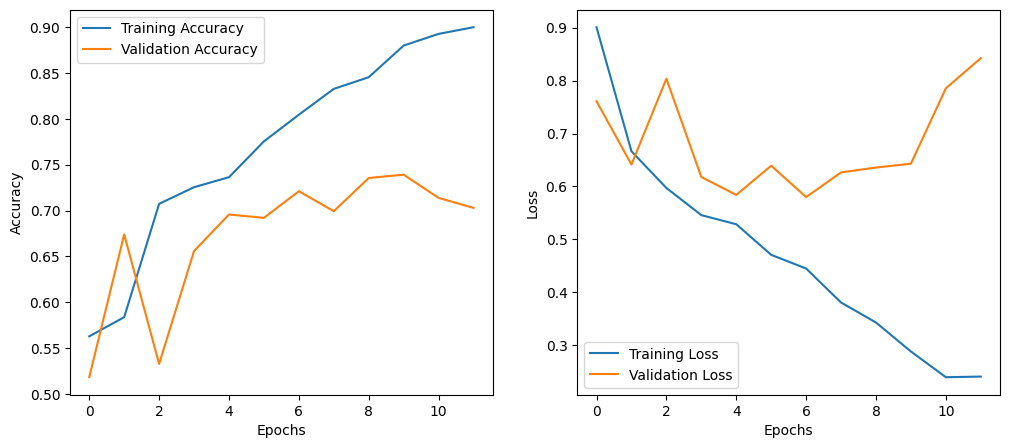

In [20]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [21]:
# Evaluate the model on the validation set
print("\nEvaluating on Validation Set:")
val_loss, val_accuracy = model.evaluate(val_dataset, verbose=1)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

# Make predictions on the validation set
y_val_pred_probs = model.predict(val_dataset)
y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()
y_val_true = np.concatenate([y for x, y in val_dataset], axis=0)


Evaluating on Validation Set:
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 799ms/step - accuracy: 0.7323 - loss: 0.5940
Validation accuracy: 72.10%
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 846ms/step



Confusion Matrix for Validation Set:


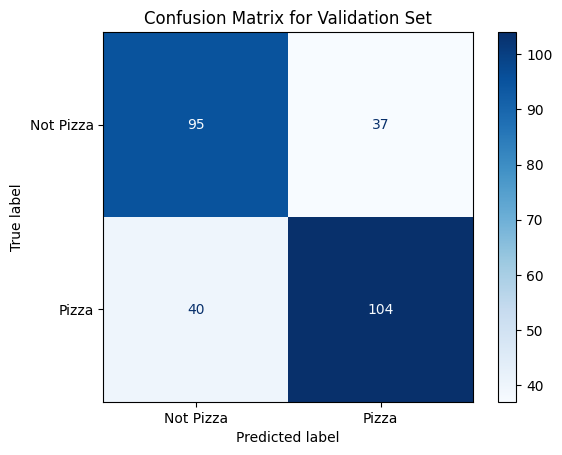


Classification Report for Validation Set:
              precision    recall  f1-score   support

   Not Pizza       0.70      0.72      0.71       132
       Pizza       0.74      0.72      0.73       144

    accuracy                           0.72       276
   macro avg       0.72      0.72      0.72       276
weighted avg       0.72      0.72      0.72       276



In [22]:
# Confusion Matrix for Validation Set
print("\nConfusion Matrix for Validation Set:")
val_cm = confusion_matrix(y_val_true, y_val_pred)
ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=['Not Pizza', 'Pizza']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Classification Report for Validation Set
print("\nClassification Report for Validation Set:")
print(classification_report(y_val_true, y_val_pred, target_names=['Not Pizza', 'Pizza']))

In [23]:
# Load the public dataset (images and labels from train.csv or similar source)
X_public, y_public = load_images(train_df, images_dir)  # Ensure correct filtering for public dataset if needed

# Predict on the public dataset
print("\nEvaluating on Entire Public Dataset:")
y_public_pred_probs = model.predict(X_public)
y_public_pred = (y_public_pred_probs > 0.5).astype(int).flatten()

# Calculate the accuracy
public_accuracy = accuracy_score(y_public, y_public_pred)
print(f'Accuracy on the entire public dataset: {public_accuracy * 100:.2f}%')



Evaluating on Entire Public Dataset:
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 488ms/step
Accuracy on the entire public dataset: 82.99%



Confusion Matrix for Entire Public Dataset:


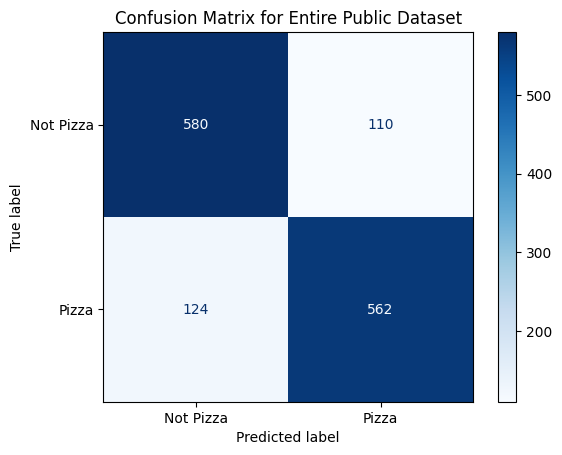


Classification Report for Entire Public Dataset:
              precision    recall  f1-score   support

   Not Pizza       0.82      0.84      0.83       690
       Pizza       0.84      0.82      0.83       686

    accuracy                           0.83      1376
   macro avg       0.83      0.83      0.83      1376
weighted avg       0.83      0.83      0.83      1376



In [24]:
# Confusion Matrix
print("\nConfusion Matrix for Entire Public Dataset:")
public_cm = confusion_matrix(y_public, y_public_pred)
ConfusionMatrixDisplay(confusion_matrix=public_cm, display_labels=['Not Pizza', 'Pizza']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Entire Public Dataset')
plt.show()

# Classification Report
print("\nClassification Report for Entire Public Dataset:")
print(classification_report(y_public, y_public_pred, target_names=['Not Pizza', 'Pizza']))

In [25]:
# Generate predictions for test dataset
y_test_pred_probs = model.predict(X_test)
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

# Prepare submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step
Submission file saved as submission.csv


In [26]:
# Save the model for future use
model.save('/kaggle/working/pizza_not_pizza_model.h5')